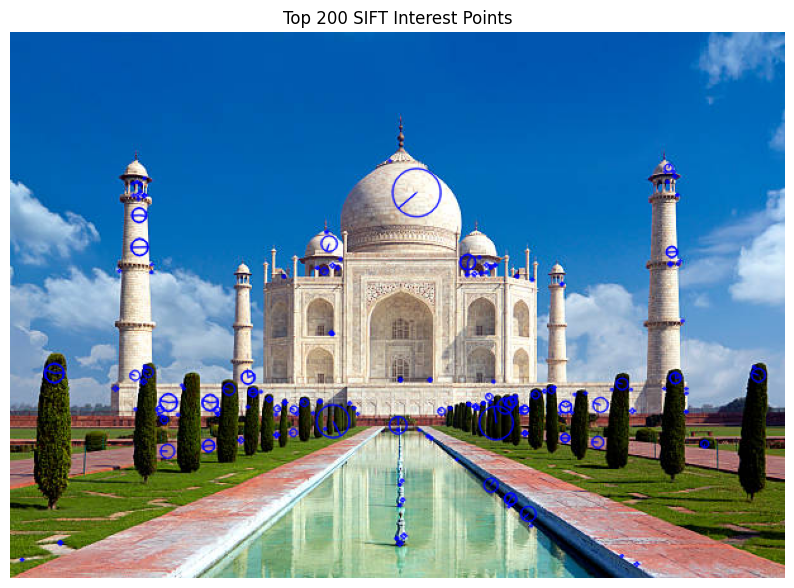

In [ ]:
import cv2
import matplotlib.pyplot as plt


image = cv2.imread('/content/TAJ.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

# Detect keypoints
keypoints = sift.detect(gray, None)

# Sort keypoints by response (strength), descending
keypoints = sorted(keypoints, key=lambda x: -x.response)

N = 200
keypoints = keypoints[:N]
output = cv2.drawKeypoints(image, keypoints, None, color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title(f"Top {N} SIFT Interest Points")
plt.axis("off")
plt.show()


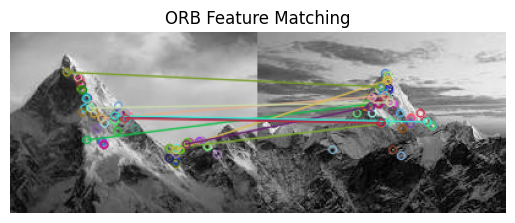

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load two images
img1 = cv2.imread('/content/11.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/12.jpeg', cv2.IMREAD_GRAYSCALE)

# ORB detector with reduced number of keypoints
orb = cv2.ORB_create(nfeatures=86)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)


matched_image = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None)

# Display result
plt.imshow(matched_image)
plt.title("ORB Feature Matching")
plt.axis('off')
plt.show()


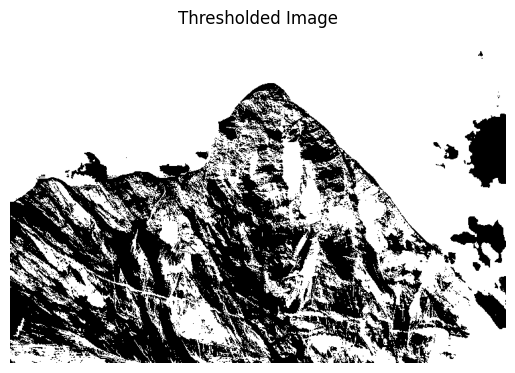

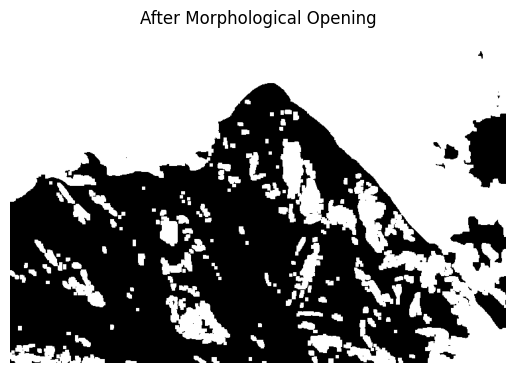

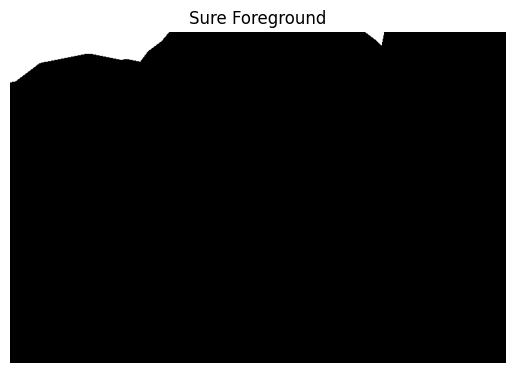

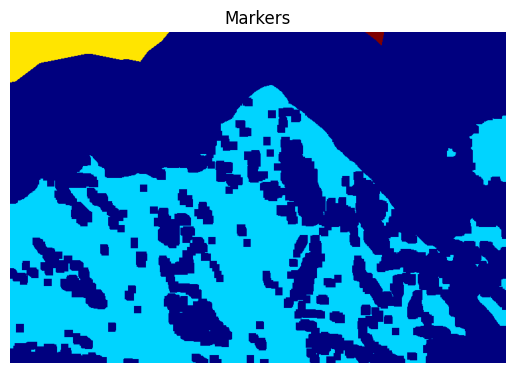

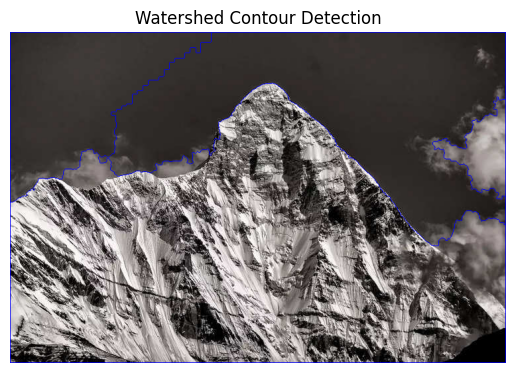

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('/content/123.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Thresholding
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Debugging step - Visualize thresholded image
plt.imshow(thresh, cmap='gray')
plt.title("Thresholded Image")
plt.axis('off')
plt.show()

# Noise removal (morphological opening)
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Debugging step - Visualize after opening
plt.imshow(opening, cmap='gray')
plt.title("After Morphological Opening")
plt.axis('off')
plt.show()

# Background and foreground
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Debugging step - Visualize sure foreground
plt.imshow(sure_fg, cmap='gray')
plt.title("Sure Foreground")
plt.axis('off')
plt.show()

# Marker labelling
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)

# Debugging step - Visualize markers
markers = markers + 1
markers[unknown == 255] = 0
plt.imshow(markers, cmap='jet')
plt.title("Markers")
plt.axis('off')
plt.show()

# Apply watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]  # Mark boundaries in red

# Visualize final result
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Watershed Contour Detection")
plt.axis('off')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
from torchvision.models import resnet18, resnet34

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet input
    transforms.ToTensor()
])

# Load CIFAR-100
trainset_full = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Use only the first 500 samples for training
train_subset = torch.utils.data.Subset(trainset_full, range(500))
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Function to train model (only for 2 epochs)
def train_model(model, epochs=2):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")

# Evaluation function
def evaluate_model(model):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    start = time.time()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    end = time.time()
    acc = 100 * correct / total
    return acc, end - start

# Load Pretrained Models
resnet18_model = resnet18(weights='IMAGENET1K_V1')
resnet34_model = resnet34(weights='IMAGENET1K_V1')

# Modify final layer for CIFAR-100
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 100)
resnet34_model.fc = nn.Linear(resnet34_model.fc.in_features, 100)

# Train and Evaluate ResNet18
print("Training ResNet18...")
train_model(resnet18_model)
acc18, time18 = evaluate_model(resnet18_model)

# Train and Evaluate ResNet34
print("\nTraining ResNet34...")
train_model(resnet34_model)
acc34, time34 = evaluate_model(resnet34_model)

# Results
print("\nComparison Summary:")
print(f"ResNet18 - Accuracy: {acc18:.2f}%, Time: {time18:.2f}s")
print(f"ResNet34 - Accuracy: {acc34:.2f}%, Time: {time34:.2f}s")


Training ResNet18...
Epoch [1/2], Loss: 76.5480
Epoch [2/2], Loss: 52.5900

Training ResNet34...
Epoch [1/2], Loss: 78.6479
Epoch [2/2], Loss: 65.7987

Comparison Summary:
ResNet18 - Accuracy: 8.48%, Time: 907.00s
ResNet34 - Accuracy: 4.80%, Time: 1614.72s


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
from torchvision.models import resnet18, resnet34

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply stronger transforms (augmentation)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-100 dataset
trainset_full = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Use first 5000 samples instead of 500
train_subset = torch.utils.data.Subset(trainset_full, range(5000))
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Training function (5 epochs)
def train_model(model, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")

# Evaluation function
def evaluate_model(model):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    start = time.time()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    end = time.time()
    acc = 100 * correct / total
    return acc, end - start

# Load and modify ResNet models
def prepare_model(resnet_fn):
    model = resnet_fn(weights="IMAGENET1K_V1")

    # Freeze all layers except the classifier
    for param in model.parameters():
        param.requires_grad = False

    # Replace FC layer for CIFAR-100
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 100)
    )

    # Enable training for new classifier layers
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

# Prepare models
resnet18_model = prepare_model(resnet18)
resnet34_model = prepare_model(resnet34)

# Train and evaluate ResNet18
print("Training ResNet18...")
train_model(resnet18_model)
acc18, time18 = evaluate_model(resnet18_model)

# Train and evaluate ResNet34
print("\nTraining ResNet34...")
train_model(resnet34_model)
acc34, time34 = evaluate_model(resnet34_model)

# Final Results
print("\nComparison Summary:")
print(f"ResNet18 - Accuracy: {acc18:.2f}%, Time: {time18:.2f}s")
print(f"ResNet34 - Accuracy: {acc34:.2f}%, Time: {time34:.2f}s")


Training ResNet18...
Epoch [1/5], Loss: 666.2755
Epoch [2/5], Loss: 496.0262
Epoch [3/5], Loss: 407.8336
Epoch [4/5], Loss: 363.4279
Epoch [5/5], Loss: 331.3089

Training ResNet34...
Epoch [1/5], Loss: 659.7532
Epoch [2/5], Loss: 483.1605
Epoch [3/5], Loss: 393.0057
Epoch [4/5], Loss: 346.0690
Epoch [5/5], Loss: 317.1363

Comparison Summary:
ResNet18 - Accuracy: 42.25%, Time: 914.35s
ResNet34 - Accuracy: 47.37%, Time: 1595.72s


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ---------- Elastic Deformation ----------
def elastic_transform(image, alpha=34, sigma=4):
    from scipy.ndimage import gaussian_filter, map_coordinates
    image = np.array(image)
    random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    distorted_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    return torch.tensor(distorted_image, dtype=torch.float32).unsqueeze(0)

# ---------- Dataset Preparation ----------
transform = transforms.Compose([
    transforms.ToTensor(),  # normalizes to [0,1]
])

mnist_full = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Apply 80-20 split
train_size = int(0.8 * len(mnist_full))
test_size = len(mnist_full) - train_size
train_dataset, test_dataset = random_split(mnist_full, [train_size, test_size])

# ---------- Episodic Sampler ----------
def create_episode(dataset, N=5, K=5, Q=5):
    class_to_indices = {}
    for idx, (img, label) in enumerate(dataset):
        class_to_indices.setdefault(label, []).append(idx)

    selected_classes = random.sample(list(class_to_indices.keys()), N)
    support_set = []
    query_set = []

    for cls in selected_classes:
        indices = random.sample(class_to_indices[cls], K + Q)
        support_indices = indices[:K]
        query_indices = indices[K:]

        for i in support_indices:
            support_set.append((dataset[i][0], cls))
        for i in query_indices:
            query_set.append((dataset[i][0], cls))

    return support_set, query_set

# ---------- Encoder Network ----------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten()
        )

    def forward(self, x):
        return self.encoder(x)

# ---------- Prototypical Network ----------
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def forward(self, support_x, support_y, query_x):
        support_embeddings = self.encoder(support_x)
        query_embeddings = self.encoder(query_x)

        unique_classes = torch.unique(support_y)
        prototypes = torch.stack([
            support_embeddings[support_y == c].mean(dim=0) for c in unique_classes
        ])

        distances = torch.cdist(query_embeddings, prototypes)
        logits = -distances  # Negative distance for softmax
        return logits

# ---------- Training + Evaluation ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
model = ProtoNet(encoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_episode(model, optimizer, dataset, N=5, K=5, Q=5):
    model.train()
    support_set, query_set = create_episode(dataset, N, K, Q)

    support_x = torch.stack([x for x, _ in support_set]).to(device)
    support_y = torch.tensor([y for _, y in support_set]).to(device)
    query_x = torch.stack([x for x, _ in query_set]).to(device)
    query_y = torch.tensor([y for _, y in query_set]).to(device)

    logits = model(support_x, support_y, query_x)
    targets = torch.tensor([list(torch.unique(support_y)).index(y.item()) for y in query_y]).to(device)

    loss = criterion(logits, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    preds = torch.argmax(logits, dim=1)
    acc = (preds == targets).float().mean().item()

    return loss.item(), acc

def evaluate(model, dataset, N=5, K=5, Q=5, episodes=20):
    model.eval()
    accs = []

    with torch.no_grad():
        for _ in range(episodes):
            support_set, query_set = create_episode(dataset, N, K, Q)
            support_x = torch.stack([x for x, _ in support_set]).to(device)
            support_y = torch.tensor([y for _, y in support_set]).to(device)
            query_x = torch.stack([x for x, _ in query_set]).to(device)
            query_y = torch.tensor([y for _, y in query_set]).to(device)

            logits = model(support_x, support_y, query_x)
            targets = torch.tensor([list(torch.unique(support_y)).index(y.item()) for y in query_y]).to(device)

            preds = torch.argmax(logits, dim=1)
            acc = (preds == targets).float().mean().item()
            accs.append(acc)

    return np.mean(accs)

# ---------- Main Training Loop ----------
EPOCHS = 20
for epoch in range(EPOCHS):
    train_loss, train_acc = train_episode(model, optimizer, train_dataset, N=5, K=5, Q=5)
    val_acc = evaluate(model, test_dataset, N=5, K=5, Q=5, episodes=10)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")



Epoch 1/20 - Loss: 1.1964, Train Acc: 0.7600, Val Acc: 0.8000
Epoch 2/20 - Loss: 0.7772, Train Acc: 0.8800, Val Acc: 0.7720
Epoch 3/20 - Loss: 1.0354, Train Acc: 0.7200, Val Acc: 0.7640
Epoch 4/20 - Loss: 0.9753, Train Acc: 0.7200, Val Acc: 0.8200
Epoch 5/20 - Loss: 0.7162, Train Acc: 0.7200, Val Acc: 0.7600
Epoch 6/20 - Loss: 0.6408, Train Acc: 0.8800, Val Acc: 0.8400
Epoch 7/20 - Loss: 1.3608, Train Acc: 0.6000, Val Acc: 0.7640
Epoch 8/20 - Loss: 0.6341, Train Acc: 0.8000, Val Acc: 0.7560
Epoch 9/20 - Loss: 0.4794, Train Acc: 0.8400, Val Acc: 0.8200
Epoch 10/20 - Loss: 0.5465, Train Acc: 0.7200, Val Acc: 0.7480
Epoch 11/20 - Loss: 0.7429, Train Acc: 0.6400, Val Acc: 0.7520
Epoch 12/20 - Loss: 0.7754, Train Acc: 0.7200, Val Acc: 0.8400
Epoch 13/20 - Loss: 0.7963, Train Acc: 0.7200, Val Acc: 0.8280
Epoch 14/20 - Loss: 0.9028, Train Acc: 0.6800, Val Acc: 0.8240
Epoch 15/20 - Loss: 0.6237, Train Acc: 0.8400, Val Acc: 0.7720
Epoch 16/20 - Loss: 0.7131, Train Acc: 0.6800, Val Acc: 0.8120
E